In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from comet_ml import Experiment

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
import optuna

from src.data.dataset import split_dataset
from src.features.features import advanced_features
from src.models.eval_plots import plot_roc_auc, plot_goal_rate, plot_cumulative_proportion, plot_calibration_curve

plt.rcParams["figure.figsize"] = (6, 6)
np.random.seed(0)

# Data Load

In [23]:
season_plays_df = pd.read_csv("./data/processed/plays_2015-2020.csv", index_col=False)
train_df, test_df = split_dataset(season_plays_df)
y_train = np.where(train_df.event_type_id=="GOAL", 1, 0)
y_test = np.where(test_df.event_type_id=="GOAL", 1, 0)

# Preprocess

In [10]:
pre_train_df = advanced_features(train_df)
pre_train_df = pre_train_df.drop(columns=["empty_net"])

C:\Users\TJ\miniconda3\envs\nice_play\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
x_train = pre_train_df[["angle_from_net", "dist_from_net"]]

# XGBoost

In [5]:
def evaluation_plots(model, X, y, model_name=None):
    y_proba = model.predict_proba(X)[:, 1]
    
    plot_roc_auc(y, y_proba, model_name=model_name)
    plot_goal_rate(y, y_proba, model_name=model_name)
    plot_cumulative_proportion(y, y_proba, model_name=model_name)
    plot_calibration_curve(y, y_proba, model_name=model_name)

## Base model

In [8]:
base_params={
    "n_estimators": 100,
    "max_depth": 4,
    "learning_rate": 0.1,
}

def run_base_xgb(X, y, params, save_run=False):
    if save_run:
        experiment = Experiment(project_name="hockey-all-star-analytics", log_graph=True)
        experiment.log_dataset_hash(X)
        
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)
        
    model = XGBClassifier(objective="binary:logistic", use_label_encoder=False, **params)
    
    model.fit(x_train, y_train,
              eval_set=[(x_val, y_val)],
              eval_metric=["logloss", "error", "auc"]
    )
    
    evaluation_plots(model, x_val, y_val, model_name="XGBoost Baseline")
    
    if save_run:
        model.save_model("./models/base_xgb.json")
        experiment.log_model("base_xgb", "./models/")
        experiment.end()
    return model

[0]	validation_0-logloss:0.62894	validation_0-error:0.09381	validation_0-auc:0.70843
[1]	validation_0-logloss:0.57646	validation_0-error:0.09381	validation_0-auc:0.71332
[2]	validation_0-logloss:0.53300	validation_0-error:0.09381	validation_0-auc:0.71464
[3]	validation_0-logloss:0.49672	validation_0-error:0.09381	validation_0-auc:0.71600
[4]	validation_0-logloss:0.46613	validation_0-error:0.09381	validation_0-auc:0.71598
[5]	validation_0-logloss:0.44022	validation_0-error:0.09381	validation_0-auc:0.71627
[6]	validation_0-logloss:0.41820	validation_0-error:0.09381	validation_0-auc:0.71772
[7]	validation_0-logloss:0.39939	validation_0-error:0.09381	validation_0-auc:0.71764
[8]	validation_0-logloss:0.38328	validation_0-error:0.09381	validation_0-auc:0.71756
[9]	validation_0-logloss:0.36948	validation_0-error:0.09381	validation_0-auc:0.71794
[10]	validation_0-logloss:0.35761	validation_0-error:0.09381	validation_0-auc:0.71884
[11]	validation_0-logloss:0.34738	validation_0-error:0.09381	val

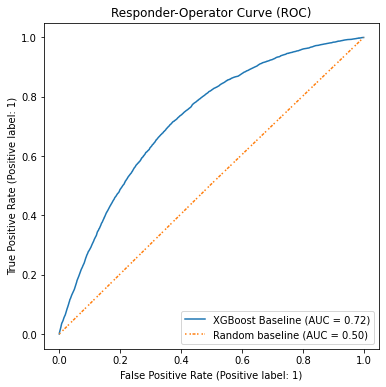

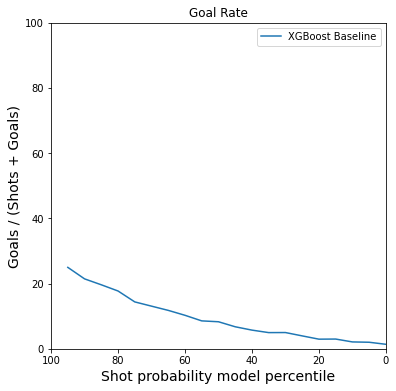

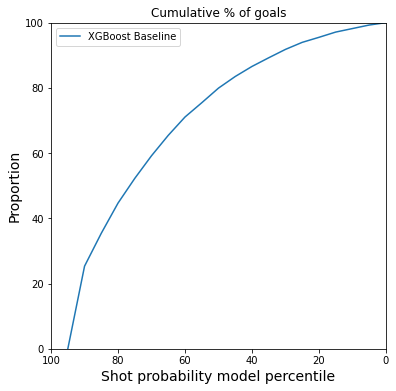

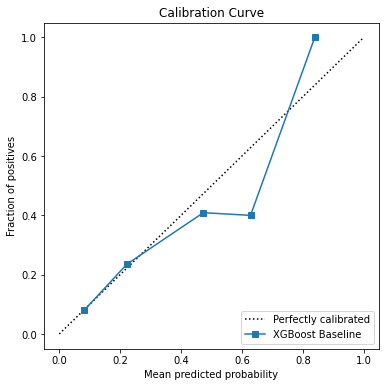

In [9]:
base_model = run_base_xgb(x_train, y_train, base_params, save_run=False)

## Tuned XGBoost

In [14]:
def objective(trial, x_df, y_df):
    hyperparams = {
        # structure
        "max_depth": trial.suggest_int("max_depth", 3, 8, step=1),
        # accuracy
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_categorical("n_estimators", [50]),
        # overfitting
        "reg_alpha": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "reg_lambda": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_child_weight": trial.suggest_float("min_gain_to_split", 0, 15),
    }
    
    kfold_cv = StratifiedKFold(n_splits=5, shuffle=True)
    cv_scores = []
    
    for idx, (train_idx, test_idx) in enumerate(kfold_cv.split(x_df, y_df)):
        x_train, x_test = x_df.iloc[train_idx], x_df.iloc[test_idx]
        y_train, y_test = y_df.iloc[train_idx], y_df.iloc[test_idx]
        
        clf = XGBClassifier(use_label_encoder=False, **hyperparams)
        clf.fit(
            x_train,
            y_train,
            eval_set=[(x_test, y_test)],
            eval_metric=["logloss", "error", "auc"],
            verbose=False,
        )
        best_score = clf.evals_result()["validation_0"]["logloss"]
        cv_scores.append(best_score)
    
    return np.mean(cv_scores)


def run_tuned_xgb(x_df, y_df, save_run=False):
    if save_run:
        experiment = Experiment(project_name="hockey-all-star-analytics", log_code=True, log_graph=True)
        
    # optimize objective to tune XGBoost
    study = optuna.create_study(direction="minimize", study_name="tuned_xgboost")
    optimize = lambda trial: objective(trial, x_df, y_df)
    study.optimize(optimize, n_trials=20)
    
    # Train the model with the best parameters
    x_train, x_val, y_train, y_val = train_test_split(x_df.values, y_df.values, test_size=0.2, stratify=y_df.values)
    best_model = XGBClassifier(**study.best_params)
    best_model.fit(x_train, y_train,
                   eval_set=[(x_val, y_val)],
                   eval_metric=["logloss", "error", "auc"])
    

    evaluation_plots(best_model, x_val, y_val, model_name="XGBoost Tuned")
    
    feature_imp = pd.DataFrame(best_model.feature_importances_.T, index=x_df.columns, columns=["Permutation Feature Importance"])
    feature_imp.sort_values(by="Permutation Feature Importance", ascending=True).plot(kind="barh")
    
    if save_run:
        best_model.save_model("./models/best_xgb.json")
        experiment.log_model("best_xgb", "./models/")
        experiment.end()
    return best_model

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/zilto/hockey-all-star-analytics/4f42440f2c70412c8fa9be07cd15b6d2
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     validation_0_auc [5050]     : (0.661964, 0.769415)
COMET INFO:     validation_0_error [5050]   : (0.092171, 0.094227)
COMET INFO:     validation_0_logloss [5050] : (0.268302, 0.666183)
COMET INFO:   Parameters:
COMET INFO:     begin_iteration  : 0
COMET INFO:     booster          : gbtree
COMET INFO:     end_iteration    : 50
COMET INFO:     eval_metric      : ['logloss', 'error', 'auc']
COMET INFO:     feature_names    : ['seconds_elapsed', 'period_idx', 'x_coord', 'y_coord', 'x_coord_norm', 'y_coord_norm', 'dist_from_net', 'angle_from_net', 'Backhand', 'Deflected', 'Slap Shot', 'Snap Shot', 'Tip-In', 'Wrap-around', 'Wrist Sh

[13:14:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "lambda_l1", "lambda_l2", "min_gain_to_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0	validation_0-logloss:0.51887	validation_0-error:0.09371	validation_0-auc:0.72301


C:\Users\TJ\miniconda3\envs\nice_play\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


1	validation_0-logloss:0.42525	validation_0-error:0.09342	validation_0-auc:0.72898
2	validation_0-logloss:0.36979	validation_0-error:0.09342	validation_0-auc:0.73136
3	validation_0-logloss:0.33560	validation_0-error:0.09342	validation_0-auc:0.73476
4	validation_0-logloss:0.31412	validation_0-error:0.09336	validation_0-auc:0.73571
5	validation_0-logloss:0.30037	validation_0-error:0.09336	validation_0-auc:0.73815
6	validation_0-logloss:0.29170	validation_0-error:0.09328	validation_0-auc:0.74039
7	validation_0-logloss:0.28613	validation_0-error:0.09328	validation_0-auc:0.74173
8	validation_0-logloss:0.28262	validation_0-error:0.09322	validation_0-auc:0.74339
9	validation_0-logloss:0.28041	validation_0-error:0.09323	validation_0-auc:0.74458
10	validation_0-logloss:0.27865	validation_0-error:0.09320	validation_0-auc:0.74682
11	validation_0-logloss:0.27758	validation_0-error:0.09325	validation_0-auc:0.74839
12	validation_0-logloss:0.27684	validation_0-error:0.09334	validation_0-auc:0.74912
1

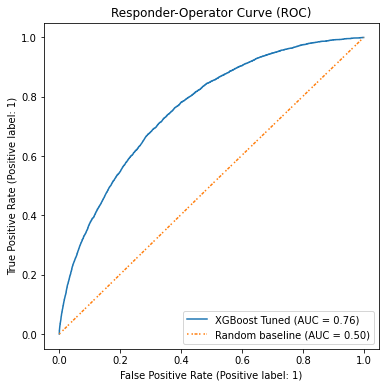

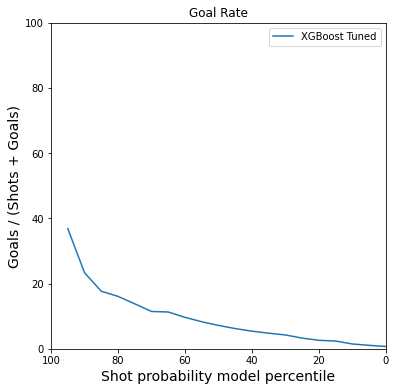

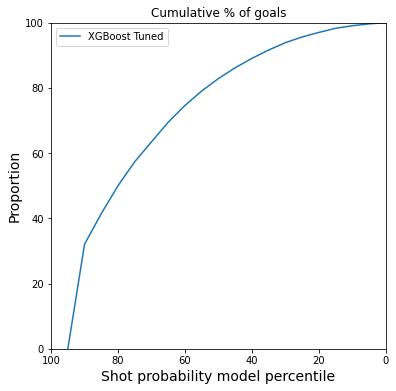

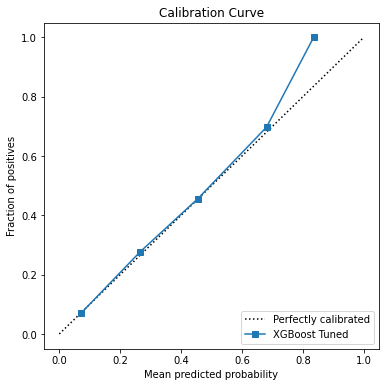

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/zilto/hockey-all-star-analytics/97d177f640b9483bb0398a951fd1b3e0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     validation_0_auc [5050]     : (0.668001, 0.76863)
COMET INFO:     validation_0_error [5050]   : (0.092268, 0.094068)
COMET INFO:     validation_0_logloss [5050] : (0.269146, 0.682421)
COMET INFO:   Parameters:
COMET INFO:     begin_iteration  : 0
COMET INFO:     booster          : gbtree
COMET INFO:     end_iteration    : 50
COMET INFO:     eval_metric      : ['logloss', 'error', 'auc']
COMET INFO:     feature_names    : ['seconds_elapsed', 'period_idx', 'x_coord', 'y_coord', 'x_coord_norm', 'y_coord_norm', 'dist_from_net', 'angle_from_net', 'Backhand', 'Deflected', 'Slap Shot', 'Snap Shot', 'Tip-In', 'Wrap-around', 'Wrist Sho

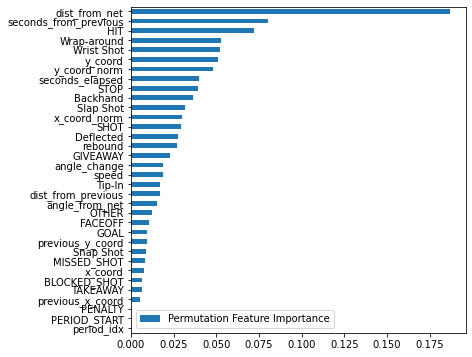

In [15]:
best_model = run_tuned_xgb(pre_train_df, pd.Series(y_train), save_run=True)

## Feature drop

In [16]:
# best_model.get_params()
best_params = {
 'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.2990984444640177,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_estimators': 50,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'lambda_l1': 45,
 'lambda_l2': 0,
 'min_gain_to_split': 14.173685506149932}

In [20]:
pre_train_df["SHOT_grouped"] = pre_train_df.BLOCKED_SHOT + pre_train_df.MISSED_SHOT + pre_train_df.SHOT
subset_df = pre_train_df.drop(columns=["period_idx", "PENALTY", "x_coord", "y_coord", "BLOCKED_SHOT", "MISSED_SHOT", "SHOT", "PERIOD_START"])

In [25]:
reduced_model = XGBClassifier(**best_params)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/zilto/hockey-all-star-analytics/c8fd976332464360a2cf29b9c90b3eb1

C:\Users\TJ\miniconda3\envs\nice_play\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:53:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "lambda_l1", "lambda_l2", "min_gain_to_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0	validation_0-logloss:0.51822	validation_0-error:0.09330	validation_0-auc:0.74195


C:\Users\TJ\miniconda3\envs\nice_play\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


1	validation_0-logloss:0.42410	validation_0-error:0.09322	validation_0-auc:0.74597
2	validation_0-logloss:0.36777	validation_0-error:0.09304	validation_0-auc:0.75060
3	validation_0-logloss:0.33288	validation_0-error:0.09310	validation_0-auc:0.75326
4	validation_0-logloss:0.31088	validation_0-error:0.09307	validation_0-auc:0.75388
5	validation_0-logloss:0.29684	validation_0-error:0.09304	validation_0-auc:0.75521
6	validation_0-logloss:0.28760	validation_0-error:0.09310	validation_0-auc:0.75721
7	validation_0-logloss:0.28185	validation_0-error:0.09301	validation_0-auc:0.75821
8	validation_0-logloss:0.27823	validation_0-error:0.09307	validation_0-auc:0.75888
9	validation_0-logloss:0.27565	validation_0-error:0.09305	validation_0-auc:0.75960
10	validation_0-logloss:0.27411	validation_0-error:0.09296	validation_0-auc:0.76030
11	validation_0-logloss:0.27301	validation_0-error:0.09292	validation_0-auc:0.76119
12	validation_0-logloss:0.27225	validation_0-error:0.09299	validation_0-auc:0.76190
1

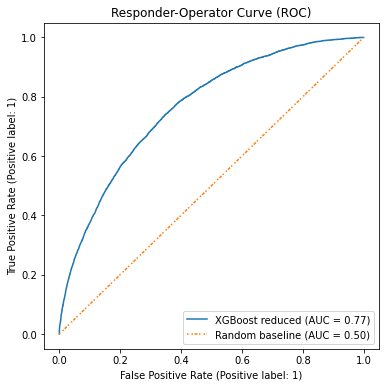

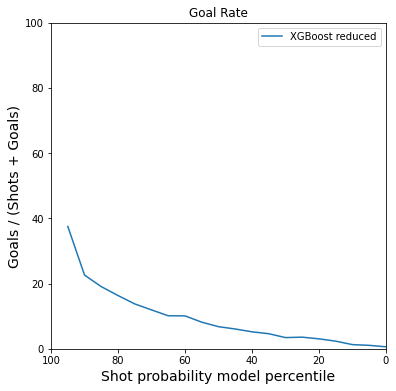

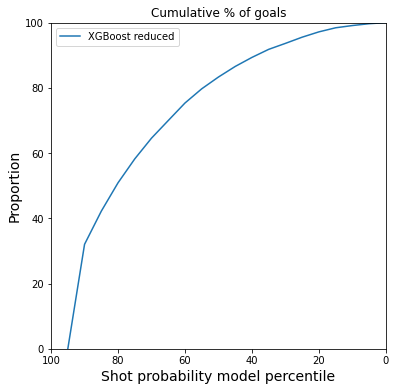

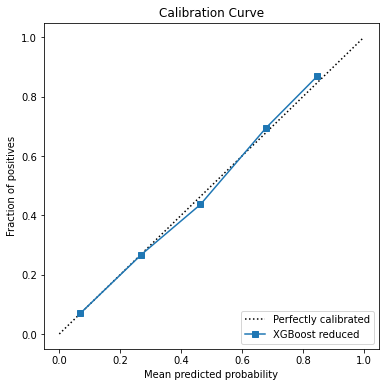

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/zilto/hockey-all-star-analytics/c8fd976332464360a2cf29b9c90b3eb1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     validation_0_auc [50]     : (0.741953, 0.765823)
COMET INFO:     validation_0_error [50]   : (0.092716, 0.093295)
COMET INFO:     validation_0_logloss [50] : (0.269521, 0.518219)
COMET INFO:   Parameters:
COMET INFO:     base_score              : 0.5
COMET INFO:     begin_iteration         : 0
COMET INFO:     booster                 : gbtree
COMET INFO:     colsample_bylevel       : 1
COMET INFO:     colsample_bynode        : 1
COMET INFO:     colsample_bytree        : 1
COMET INFO:     end_iteration           : 50
COMET INFO:     eval_metric             : ['logloss', 'error', 'auc']
COMET INFO:     gamma                   : 0

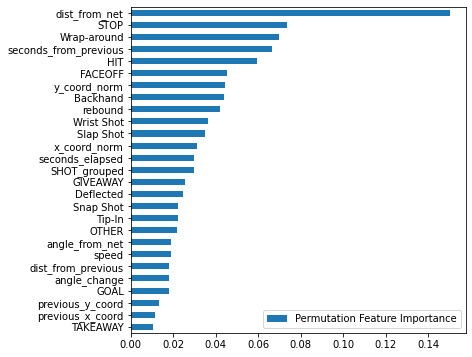

In [26]:
experiment = Experiment(project_name="hockey-all-star-analytics", log_code=True, log_graph=True)

xx_df, y_df = subset_df, pd.Series(y_train)

x_train, x_val, yy_train, y_val = train_test_split(xx_df.values, y_df.values, test_size=0.2, stratify=y_df.values)
reduced_model = XGBClassifier(**best_params)
reduced_model.fit(x_train, yy_train,
                   eval_set=[(x_val, y_val)],
                   eval_metric=["logloss", "error", "auc"])
    

y_proba = reduced_model.predict_proba(x_val)[:, 1]

evaluation_plots(reduced_model, x_val, y_val, model_name="XGBoost reduced")

feature_imp = pd.DataFrame(reduced_model.feature_importances_.T, index=xx_df.columns, columns=["Permutation Feature Importance"])
feature_imp.sort_values(by="Permutation Feature Importance", ascending=True).plot(kind="barh")

reduced_model.save_model("./models/reduced_xgb.json")
experiment.log_model("reduced_xgb", "./models/")
experiment.end()